In [1]:
import os
import json
import torch
import pprint
import numpy as np
from tensorboard_logger import Logger as TbLogger
import warnings
from problems.problem_tsp import TSP
from problems.problem_vrp import CVRP
from agent.ppo import PPO
from tqdm.notebook import tqdm
from options import get_options
from torch.utils.data import DataLoader
from problems.problem_tsp import TSPDataset
import torch
from matplotlib import pyplot as plt
from problems.problem_tsp import get_real_seq
import tensorflow as tf

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/tsp_20

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 8843), started 0:01:55 ago. (Use '!kill 8843' to kill it.)

In [10]:
# import glob
# import tensorflow as tf

# def get_section_results(file):
#     """
#         requires tensorflow==1.12.0
#     """
#     X = []
#     Y = []
#     for e in tf.train.summary_iterator(file):
#         for v in e.summary.value:
#             if v.tag == 'Train_EnvstepsSoFar':
#                 X.append(v.simple_value)
#             elif v.tag == 'Eval_AverageReturn':
#                 Y.append(v.simple_value)
#     return X, Y

# if __name__ == '__main__':
#     import glob

#     logdir = 'data/q1_lb_rtg_na_CartPole-v0_13-09-2020_23-32-10/events*'
#     eventfile = glob.glob(logdir)[0]

#     X, Y = get_section_results(eventfile)
#     for i, (x, y) in enumerate(zip(X, Y)):
#         print('Iteration {:d} | Train steps: {:d} | Return: {}'.format(i, int(x), y))

In [9]:
import glob
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

eventfile = '/home/jiaman/VRP-DACT-new_version/logs/tsp_20/run_name_20221207T211024/events.out.tfevents.1670476224.ASUS13'

for e in tf.train.summary_iterator(eventfile):
    for v in e.summary.value:
        print(v.tag)

In [2]:
def load_agent(name):
    agent = {
        'ppo': PPO,
    }.get(name, None)
    assert agent is not None, "Currently unsupported agent: {}!".format(name)
    return agent

def load_problem(name):
    problem = {
        'tsp': TSP,
        'vrp': CVRP,
    }.get(name, None)
    assert problem is not None, "Currently unsupported problem: {}!".format(name)
    return problem

def plot_tour(rec, coordinates, dpi = 300):
    plt.figure(figsize=(8,6))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axis([-0.05, 1.05]*2)
    # plot the nodes
    plt.scatter(coordinates[:,0], coordinates[:,1], marker = 'H', s = 55, c = 'blue', zorder = 2)
    # plot the tour
    real_seq = get_real_seq(rec.unsqueeze(0))
    real_seq_coordinates = coordinates.gather(0,real_seq[0].unsqueeze(1).repeat(1,2))
    real_seq_coordinates = torch.cat((real_seq_coordinates, real_seq_coordinates[:1]),0)
    plt.plot(real_seq_coordinates[:,0], real_seq_coordinates[:,1], color = 'black', zorder = 1)
    # mark node
    for i,txt in enumerate(range(rec.size(0))):
        plt.annotate(txt,(coordinates[i,0]+0.01, coordinates[i,1]+0.01),)
    plt.show()

In [10]:
# opts = get_options('')
# opts.problem = 'tsp'
# opts.graph_size = 20
# opts.val_dataset='./datasets/tsp_20_10000.pkl'
# opts.step_method = '2_opt'
# opts.init_val_met = 'random'
# opts.no_saving = False
# opts.no_tb = False
# opts.batch_size = 16
# opts.epoch_end = 100
# opts.epoch_size = 128
# opts.T_max = 1000
# opts.val_size = 10
# opts.device = torch.device("cuda" if opts.use_cuda else "cpu")

# tb_logger = None
# if not opts.no_tb and not opts.distributed:
#     tb_logger = TbLogger(os.path.join(opts.log_dir, "{}_{}".format(opts.problem, 
#                                                       opts.graph_size), opts.run_name))
# if not opts.no_saving and not os.path.exists(opts.save_dir):
#     os.makedirs(opts.save_dir)
# if not opts.no_saving:
#     with open(os.path.join(opts.save_dir, "args.json"), 'w') as f:
#         json.dump(vars(opts), f, indent=True)

# problem = load_problem(opts.problem)(
#                         p_size = opts.graph_size,
#                         step_method = opts.step_method,
#                         init_val_met = opts.init_val_met,
#                         with_assert = opts.use_assert,
#                         P = opts.P,
#                         DUMMY_RATE = opts.dummy_rate)
# exp_dual = False; exp_encoder='attention'; exp_decoder = 'rnn' 
# agent = load_agent(opts.RL_agent)(exp_dual, exp_encoder, exp_decoder, problem.NAME, problem.size,  opts)
# agent.start_training(problem, opts.val_dataset, tb_logger)

TSP with 20 nodes.  Do assert: False


In [14]:
for exp_dual in [False,True]:
    for exp_encoder in ['attention']:
            for exp_decoder in ['attention']:
                opts = get_options('')
                opts.problem = 'tsp'
                opts.graph_size = 20
                opts.val_dataset='./datasets/tsp_20_10000.pkl'
                opts.step_method = '2_opt'
                opts.init_val_met = 'random'
                opts.no_saving = False
                opts.no_tb = False
                opts.batch_size = 16
                opts.epoch_end = 200
                opts.epoch_size = 128
                opts.T_max = 1000
                opts.val_size = 10
                opts.device = torch.device("cuda" if opts.use_cuda else "cpu")

                tb_logger = None
                if not opts.no_tb and not opts.distributed:
                    tb_logger = TbLogger(os.path.join(opts.log_dir, "{}_{}".format(opts.problem, 
                                                                    opts.graph_size), opts.run_name))
                if not opts.no_saving and not os.path.exists(opts.save_dir):
                    os.makedirs(opts.save_dir)
                if not opts.no_saving:
                    with open(os.path.join(opts.save_dir, "args.json"), 'w') as f:
                        json.dump(list(vars(opts)), f, indent=True)

                problem = load_problem(opts.problem)(
                                        p_size = opts.graph_size,
                                        step_method = opts.step_method,
                                        init_val_met = opts.init_val_met,
                                        with_assert = opts.use_assert,
                                        P = opts.P,
                                        DUMMY_RATE = opts.dummy_rate)
                agent = load_agent(opts.RL_agent)(exp_dual, exp_encoder, exp_decoder, problem.NAME, problem.size,  opts)
                agent.start_training(problem, opts.val_dataset, tb_logger)

In [3]:
for exp_dual in [False]:
    for exp_encoder in ['rnn']:
            for exp_decoder in ['attention']:
            #for exp_decoder in ['rnn']:
                opts = get_options('')
                opts.problem = 'tsp'
                opts.graph_size = 20
                opts.val_dataset='./datasets/tsp_20_10000.pkl'
                opts.step_method = '2_opt'
                opts.init_val_met = 'random'
                opts.no_saving = False
                opts.no_tb = False
                opts.batch_size = 16
                opts.epoch_end = 200
                opts.epoch_size = 128
                opts.T_max = 1000
                opts.val_size = 10
                opts.device = torch.device("cuda" if opts.use_cuda else "cpu")

                tb_logger = None
                if not opts.no_tb and not opts.distributed:
                    tb_logger = TbLogger(os.path.join(opts.log_dir, "{}_{}".format(opts.problem, 
                                                                    opts.graph_size), opts.run_name))
                if not opts.no_saving and not os.path.exists(opts.save_dir):
                    os.makedirs(opts.save_dir)
                if not opts.no_saving:
                    with open(os.path.join(opts.save_dir, "args.json"), 'w') as f:
                        json.dump(list(vars(opts)), f, indent=True)

                problem = load_problem(opts.problem)(
                                        p_size = opts.graph_size,
                                        step_method = opts.step_method,
                                        init_val_met = opts.init_val_met,
                                        with_assert = opts.use_assert,
                                        P = opts.P,
                                        DUMMY_RATE = opts.dummy_rate)

                agent = load_agent(opts.RL_agent)(exp_dual, exp_encoder, exp_decoder, problem.NAME, problem.size,  opts)
                agent.start_training(problem, opts.val_dataset, tb_logger)

TSP with 20 nodes.  Do assert: False
{'Total': 1364873, 'Trainable': 1364873}
Distributed: False



| ********************* Training epoch 0 ********************* |
Training with actor lr=1.000e-04 critic lr=3.000e-05 for run run_name_20221212T102301


/home/jiaman/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
training:   0%|                    | 0/1200 [00:00<?, ?it/s]

128 instances initialized.


training: 100%|████████████████████| 1200/1200 [06:41<00:00,  2.99it/s]

Saving model and state...

Inference with x1 augments...



rollout:   1%|▎                   | 13/1000 [00:00<00:07, 128.61it/s]

10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:07<00:00, 140.25it/s]


 ------------------------------------------------------------
         Avg total reward:          2.467678   +- 0.164982  
          Avg step reward:          0.002468   +- 0.011368  
------------------------------------------------------------
           Avg init cost:           10.066249  +- 0.309449  
    Avg cost after T=500 steps:     9.877872   +- 0.484421  
    Avg cost after T=1000 steps:    9.931221   +- 0.452398  
------------------------------------------------------------
  Avg best cost after T=500 steps:  7.865211   +- 0.226663  
 Avg best cost after T=1000 steps:  7.598572   +- 0.244007  
        Avg final best cost:        7.598572   +- 0.244007  
------------------------------------------------------------
           Avg used time:           0.713554s
------------------------------------------------------------ 




| ********************* Training epoch 1 ********************* |
Training with actor lr=9.850e-05 critic lr=2.955e-05 for run run_name_20221212T102301



training:   0%|                    | 0/1200 [00:00<?, ?it/s]

128 instances initialized.


training: 100%|████████████████████| 1200/1200 [06:43<00:00,  2.97it/s]

Saving model and state...

Inference with x1 augments...



rollout:   1%|▎                   | 14/1000 [00:00<00:07, 137.07it/s]

10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:07<00:00, 141.58it/s]


 ------------------------------------------------------------
         Avg total reward:          2.963000   +- 0.346623  
          Avg step reward:          0.002963   +- 0.011992  
------------------------------------------------------------
           Avg init cost:           10.461775  +- 0.389780  
    Avg cost after T=500 steps:     10.499338  +- 0.347235  
    Avg cost after T=1000 steps:    10.611096  +- 0.485545  
------------------------------------------------------------
  Avg best cost after T=500 steps:  7.843834   +- 0.303832  
 Avg best cost after T=1000 steps:  7.498776   +- 0.245014  
        Avg final best cost:        7.498776   +- 0.245014  
------------------------------------------------------------
           Avg used time:           0.706886s
------------------------------------------------------------ 




| ********************* Training epoch 2 ********************* |
Training with actor lr=9.702e-05 critic lr=2.911e-05 for run run_name_20221212T102301



training:   0%|                    | 0/1200 [00:00<?, ?it/s]

128 instances initialized.


training: 100%|████████████████████| 1200/1200 [06:48<00:00,  2.93it/s]

Saving model and state...

Inference with x1 augments...



rollout:   1%|▎                   | 14/1000 [00:00<00:07, 136.75it/s]

10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:07<00:00, 141.93it/s]


 ------------------------------------------------------------
         Avg total reward:          2.620272   +- 0.229661  
          Avg step reward:          0.002620   +- 0.011718  
------------------------------------------------------------
           Avg init cost:           10.379028  +- 0.312299  
    Avg cost after T=500 steps:     10.875911  +- 0.418911  
    Avg cost after T=1000 steps:    10.485417  +- 0.403837  
------------------------------------------------------------
  Avg best cost after T=500 steps:  7.941434   +- 0.224580  
 Avg best cost after T=1000 steps:  7.758756   +- 0.197349  
        Avg final best cost:        7.758756   +- 0.197349  
------------------------------------------------------------
           Avg used time:           0.705122s
------------------------------------------------------------ 




| ********************* Training epoch 3 ********************* |
Training with actor lr=9.557e-05 critic lr=2.867e-05 for run run_name_20221212T102301



training:   0%|                    | 0/1200 [00:00<?, ?it/s]

128 instances initialized.


training: 100%|████████████████████| 1200/1200 [06:47<00:00,  2.94it/s]

Saving model and state...

Inference with x1 augments...



rollout:   1%|▎                   | 14/1000 [00:00<00:07, 135.51it/s]

10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:07<00:00, 140.57it/s]


 ------------------------------------------------------------
         Avg total reward:          2.695885   +- 0.365947  
          Avg step reward:          0.002696   +- 0.011817  
------------------------------------------------------------
           Avg init cost:           10.073918  +- 0.486697  
    Avg cost after T=500 steps:     10.415712  +- 0.530473  
    Avg cost after T=1000 steps:    10.543493  +- 0.337404  
------------------------------------------------------------
  Avg best cost after T=500 steps:  7.660803   +- 0.225601  
 Avg best cost after T=1000 steps:  7.378032   +- 0.201854  
        Avg final best cost:        7.378033   +- 0.201854  
------------------------------------------------------------
           Avg used time:           0.711958s
------------------------------------------------------------ 




| ********************* Training epoch 4 ********************* |
Training with actor lr=9.413e-05 critic lr=2.824e-05 for run run_name_20221212T102301



training:   0%|                    | 0/1200 [00:00<?, ?it/s]

128 instances initialized.


training: 100%|████████████████████| 1200/1200 [06:48<00:00,  2.94it/s]

Saving model and state...

Inference with x1 augments...



rollout:   1%|▎                   | 14/1000 [00:00<00:07, 135.37it/s]

10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:07<00:00, 142.15it/s]


 ------------------------------------------------------------
         Avg total reward:          2.291670   +- 0.213738  
          Avg step reward:          0.002292   +- 0.010487  
------------------------------------------------------------
           Avg init cost:           10.021561  +- 0.350533  
    Avg cost after T=500 steps:     9.759122   +- 0.335819  
    Avg cost after T=1000 steps:    10.317411  +- 0.486383  
------------------------------------------------------------
  Avg best cost after T=500 steps:  7.777388   +- 0.280058  
 Avg best cost after T=1000 steps:  7.729890   +- 0.277348  
        Avg final best cost:        7.729890   +- 0.277348  
------------------------------------------------------------
           Avg used time:           0.704146s
------------------------------------------------------------ 




| ********************* Training epoch 5 ********************* |
Training with actor lr=9.272e-05 critic lr=2.782e-05 for run run_name_20221212T102301



training:   0%|                    | 0/1200 [00:00<?, ?it/s]

128 instances initialized.


training: 100%|████████████████████| 1200/1200 [06:48<00:00,  2.94it/s]

Saving model and state...

Inference with x1 augments...



rollout:   1%|▎                   | 14/1000 [00:00<00:07, 136.24it/s]

10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:07<00:00, 141.17it/s]


 ------------------------------------------------------------
         Avg total reward:          2.837865   +- 0.330433  
          Avg step reward:          0.002838   +- 0.011111  
------------------------------------------------------------
           Avg init cost:           10.318175  +- 0.440588  
    Avg cost after T=500 steps:     10.287251  +- 0.374964  
    Avg cost after T=1000 steps:    10.189354  +- 0.340172  
------------------------------------------------------------
  Avg best cost after T=500 steps:  7.654149   +- 0.253961  
 Avg best cost after T=1000 steps:  7.480310   +- 0.207406  
        Avg final best cost:        7.480310   +- 0.207406  
------------------------------------------------------------
           Avg used time:           0.709040s
------------------------------------------------------------ 




| ********************* Training epoch 6 ********************* |
Training with actor lr=9.133e-05 critic lr=2.740e-05 for run run_name_20221212T102301



training:   0%|                    | 0/1200 [00:00<?, ?it/s]

128 instances initialized.


training: 100%|████████████████████| 1200/1200 [07:27<00:00,  2.68it/s]

Saving model and state...

Inference with x1 augments...



rollout:   1%|▏                   | 9/1000 [00:00<00:11, 87.26it/s]

10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:07<00:00, 139.84it/s]


 ------------------------------------------------------------
         Avg total reward:          2.419371   +- 0.194082  
          Avg step reward:          0.002419   +- 0.010006  
------------------------------------------------------------
           Avg init cost:           9.985191   +- 0.354140  
    Avg cost after T=500 steps:     11.137024  +- 0.391130  
    Avg cost after T=1000 steps:    11.048115  +- 0.496050  
------------------------------------------------------------
  Avg best cost after T=500 steps:  7.735011   +- 0.252814  
 Avg best cost after T=1000 steps:  7.565820   +- 0.246815  
        Avg final best cost:        7.565820   +- 0.246815  
------------------------------------------------------------
           Avg used time:           0.715817s
------------------------------------------------------------ 




| ********************* Training epoch 7 ********************* |
Training with actor lr=8.996e-05 critic lr=2.699e-05 for run run_name_20221212T102301



training:   0%|                    | 0/1200 [00:00<?, ?it/s]

128 instances initialized.


training: 100%|████████████████████| 1200/1200 [06:51<00:00,  2.92it/s]

Saving model and state...

Inference with x1 augments...



rollout:   1%|▎                   | 14/1000 [00:00<00:07, 135.57it/s]

10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:07<00:00, 139.85it/s]


 ------------------------------------------------------------
         Avg total reward:          3.309762   +- 0.278225  
          Avg step reward:          0.003310   +- 0.012950  
------------------------------------------------------------
           Avg init cost:           10.684702  +- 0.383825  
    Avg cost after T=500 steps:     10.465625  +- 0.391422  
    Avg cost after T=1000 steps:    10.413708  +- 0.403957  
------------------------------------------------------------
  Avg best cost after T=500 steps:  7.662297   +- 0.320324  
 Avg best cost after T=1000 steps:  7.374939   +- 0.228471  
        Avg final best cost:        7.374938   +- 0.228471  
------------------------------------------------------------
           Avg used time:           0.715754s
------------------------------------------------------------ 




| ********************* Training epoch 8 ********************* |
Training with actor lr=8.861e-05 critic lr=2.658e-05 for run run_name_20221212T102301



training:   0%|                    | 0/1200 [00:00<?, ?it/s]

128 instances initialized.


training: 100%|████████████████████| 1200/1200 [06:52<00:00,  2.91it/s]

Saving model and state...

Inference with x1 augments...



rollout:   1%|▎                   | 14/1000 [00:00<00:07, 135.65it/s]

10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:07<00:00, 140.69it/s]


 ------------------------------------------------------------
         Avg total reward:          2.830299   +- 0.240758  
          Avg step reward:          0.002830   +- 0.010992  
------------------------------------------------------------
           Avg init cost:           10.464057  +- 0.398999  
    Avg cost after T=500 steps:     10.705153  +- 0.534274  
    Avg cost after T=1000 steps:    10.373947  +- 0.244980  
------------------------------------------------------------
  Avg best cost after T=500 steps:  7.808732   +- 0.221587  
 Avg best cost after T=1000 steps:  7.633759   +- 0.210598  
        Avg final best cost:        7.633758   +- 0.210598  
------------------------------------------------------------
           Avg used time:           0.711450s
------------------------------------------------------------ 




| ********************* Training epoch 9 ********************* |
Training with actor lr=8.728e-05 critic lr=2.618e-05 for run run_name_20221212T102301



training:   0%|                    | 0/1200 [00:00<?, ?it/s]

128 instances initialized.


training: 100%|████████████████████| 1200/1200 [07:06<00:00,  2.81it/s]

Saving model and state...

Inference with x1 augments...



rollout:   1%|▏                   | 10/1000 [00:00<00:10, 98.08it/s]

10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:12<00:00, 82.01it/s]


 ------------------------------------------------------------
         Avg total reward:          3.606869   +- 0.360052  
          Avg step reward:          0.003607   +- 0.013641  
------------------------------------------------------------
           Avg init cost:           10.885472  +- 0.367629  
    Avg cost after T=500 steps:     10.101429  +- 0.417798  
    Avg cost after T=1000 steps:    10.710955  +- 0.328439  
------------------------------------------------------------
  Avg best cost after T=500 steps:  7.584353   +- 0.244486  
 Avg best cost after T=1000 steps:  7.278603   +- 0.167055  
        Avg final best cost:        7.278603   +- 0.167055  
------------------------------------------------------------
           Avg used time:           1.220249s
------------------------------------------------------------ 




| ******************** Training epoch 10 ********************* |
Training with actor lr=8.597e-05 critic lr=2.579e-05 for run run_name_20221212T102301



training:   0%|                    | 0/1200 [00:00<?, ?it/s]

128 instances initialized.


training: 100%|████████████████████| 1200/1200 [09:23<00:00,  2.13it/s]

Saving model and state...

Inference with x1 augments...



rollout:   1%|▏                   | 10/1000 [00:00<00:10, 97.48it/s]

10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:10<00:00, 97.21it/s]


 ------------------------------------------------------------
         Avg total reward:          2.635792   +- 0.260491  
          Avg step reward:          0.002636   +- 0.011752  
------------------------------------------------------------
           Avg init cost:           10.389643  +- 0.352701  
    Avg cost after T=500 steps:     10.698253  +- 0.305795  
    Avg cost after T=1000 steps:    10.830046  +- 0.497320  
------------------------------------------------------------
  Avg best cost after T=500 steps:  7.909332   +- 0.283272  
 Avg best cost after T=1000 steps:  7.753850   +- 0.295427  
        Avg final best cost:        7.753850   +- 0.295427  
------------------------------------------------------------
           Avg used time:           1.029703s
------------------------------------------------------------ 




| ******************** Training epoch 11 ********************* |
Training with actor lr=8.468e-05 critic lr=2.541e-05 for run run_name_20221212T102301



training:   0%|                    | 0/1200 [00:00<?, ?it/s]

128 instances initialized.


training: 100%|████████████████████| 1200/1200 [09:13<00:00,  2.17it/s]

Saving model and state...

Inference with x1 augments...



rollout:   1%|▏                   | 10/1000 [00:00<00:10, 96.13it/s]

10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:09<00:00, 102.07it/s]


 ------------------------------------------------------------
         Avg total reward:          2.297688   +- 0.233482  
          Avg step reward:          0.002298   +- 0.010386  
------------------------------------------------------------
           Avg init cost:           9.944084   +- 0.380519  
    Avg cost after T=500 steps:     10.701069  +- 0.420827  
    Avg cost after T=1000 steps:    10.758448  +- 0.415295  
------------------------------------------------------------
  Avg best cost after T=500 steps:  8.010229   +- 0.223354  
 Avg best cost after T=1000 steps:  7.646397   +- 0.252306  
        Avg final best cost:        7.646396   +- 0.252306  
------------------------------------------------------------
           Avg used time:           0.980913s
------------------------------------------------------------ 




| ******************** Training epoch 12 ********************* |
Training with actor lr=8.341e-05 critic lr=2.502e-05 for run run_name_20221212T102301



training:   0%|                    | 0/1200 [00:00<?, ?it/s]

128 instances initialized.


training: 100%|████████████████████| 1200/1200 [09:14<00:00,  2.16it/s]

Saving model and state...

Inference with x1 augments...



rollout:   1%|▏                   | 11/1000 [00:00<00:09, 102.40it/s]

10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:09<00:00, 103.76it/s]


 ------------------------------------------------------------
         Avg total reward:          3.546305   +- 0.395855  
          Avg step reward:          0.003546   +- 0.013220  
------------------------------------------------------------
           Avg init cost:           11.125219  +- 0.528373  
    Avg cost after T=500 steps:     10.108236  +- 0.321240  
    Avg cost after T=1000 steps:    10.535493  +- 0.507350  
------------------------------------------------------------
  Avg best cost after T=500 steps:  7.878348   +- 0.185813  
 Avg best cost after T=1000 steps:  7.578916   +- 0.198575  
        Avg final best cost:        7.578915   +- 0.198575  
------------------------------------------------------------
           Avg used time:           0.964845s
------------------------------------------------------------ 




| ******************** Training epoch 13 ********************* |
Training with actor lr=8.216e-05 critic lr=2.465e-05 for run run_name_20221212T102301



training:   0%|                    | 0/1200 [00:00<?, ?it/s]

128 instances initialized.


training: 100%|████████████████████| 1200/1200 [09:11<00:00,  2.18it/s]

Saving model and state...

Inference with x1 augments...



rollout:   1%|▏                   | 11/1000 [00:00<00:09, 101.53it/s]

10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:10<00:00, 91.73it/s]


 ------------------------------------------------------------
         Avg total reward:          2.649500   +- 0.334948  
          Avg step reward:          0.002650   +- 0.010937  
------------------------------------------------------------
           Avg init cost:           10.269934  +- 0.497770  
    Avg cost after T=500 steps:     10.772740  +- 0.425181  
    Avg cost after T=1000 steps:    10.678729  +- 0.471532  
------------------------------------------------------------
  Avg best cost after T=500 steps:  8.055826   +- 0.301483  
 Avg best cost after T=1000 steps:  7.620435   +- 0.305690  
        Avg final best cost:        7.620434   +- 0.305690  
------------------------------------------------------------
           Avg used time:           1.091212s
------------------------------------------------------------ 




| ******************** Training epoch 14 ********************* |
Training with actor lr=8.093e-05 critic lr=2.428e-05 for run run_name_20221212T102301



training:   0%|                    | 0/1200 [00:00<?, ?it/s]

128 instances initialized.


training: 100%|████████████████████| 1200/1200 [09:18<00:00,  2.15it/s]

Saving model and state...

Inference with x1 augments...



rollout:   1%|▏                   | 11/1000 [00:00<00:09, 100.52it/s]

10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:09<00:00, 102.02it/s]


 ------------------------------------------------------------
         Avg total reward:          2.444851   +- 0.387570  
          Avg step reward:          0.002445   +- 0.010021  
------------------------------------------------------------
           Avg init cost:           10.081781  +- 0.538468  
    Avg cost after T=500 steps:     10.790418  +- 0.517471  
    Avg cost after T=1000 steps:    10.023465  +- 0.528075  
------------------------------------------------------------
  Avg best cost after T=500 steps:  8.165779   +- 0.269307  
 Avg best cost after T=1000 steps:  7.636929   +- 0.278841  
        Avg final best cost:        7.636930   +- 0.278841  
------------------------------------------------------------
           Avg used time:           0.981423s
------------------------------------------------------------ 




| ******************** Training epoch 15 ********************* |
Training with actor lr=7.972e-05 critic lr=2.391e-05 for run run_name_20221212T102301



training:   0%|                    | 0/1200 [00:00<?, ?it/s]

128 instances initialized.


training: 100%|████████████████████| 1200/1200 [09:08<00:00,  2.19it/s]

Saving model and state...

Inference with x1 augments...



rollout:   1%|▎                   | 14/1000 [00:00<00:07, 133.37it/s]

10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:07<00:00, 139.43it/s]


 ------------------------------------------------------------
         Avg total reward:          3.034344   +- 0.254699  
          Avg step reward:          0.003034   +- 0.011488  
------------------------------------------------------------
           Avg init cost:           10.721646  +- 0.328555  
    Avg cost after T=500 steps:     10.210754  +- 0.289574  
    Avg cost after T=1000 steps:    10.400313  +- 0.370722  
------------------------------------------------------------
  Avg best cost after T=500 steps:  7.961054   +- 0.234678  
 Avg best cost after T=1000 steps:  7.687301   +- 0.214607  
        Avg final best cost:        7.687301   +- 0.214607  
------------------------------------------------------------
           Avg used time:           0.717958s
------------------------------------------------------------ 




| ******************** Training epoch 16 ********************* |
Training with actor lr=7.852e-05 critic lr=2.356e-05 for run run_name_20221212T102301



training:   0%|                    | 0/1200 [00:00<?, ?it/s]

128 instances initialized.


training: 100%|████████████████████| 1200/1200 [06:58<00:00,  2.87it/s]

Saving model and state...

Inference with x1 augments...



rollout:   1%|▎                   | 14/1000 [00:00<00:07, 131.37it/s]

10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:07<00:00, 139.73it/s]


 ------------------------------------------------------------
         Avg total reward:          2.771223   +- 0.386485  
          Avg step reward:          0.002771   +- 0.010712  
------------------------------------------------------------
           Avg init cost:           10.484392  +- 0.552503  
    Avg cost after T=500 steps:     10.886312  +- 0.387082  
    Avg cost after T=1000 steps:    10.593374  +- 0.500412  
------------------------------------------------------------
  Avg best cost after T=500 steps:  7.805770   +- 0.244259  
 Avg best cost after T=1000 steps:  7.713170   +- 0.215676  
        Avg final best cost:        7.713170   +- 0.215676  
------------------------------------------------------------
           Avg used time:           0.716437s
------------------------------------------------------------ 




| ******************** Training epoch 17 ********************* |
Training with actor lr=7.734e-05 critic lr=2.320e-05 for run run_name_20221212T102301



training:   0%|                    | 0/1200 [00:00<?, ?it/s]

128 instances initialized.


training: 100%|████████████████████| 1200/1200 [06:59<00:00,  2.86it/s]

Saving model and state...

Inference with x1 augments...



rollout:   1%|▎                   | 14/1000 [00:00<00:07, 134.40it/s]

10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:07<00:00, 139.55it/s]


 ------------------------------------------------------------
         Avg total reward:          3.162299   +- 0.318718  
          Avg step reward:          0.003162   +- 0.013135  
------------------------------------------------------------
           Avg init cost:           11.026729  +- 0.411926  
    Avg cost after T=500 steps:     10.596210  +- 0.699092  
    Avg cost after T=1000 steps:    10.344474  +- 0.439471  
------------------------------------------------------------
  Avg best cost after T=500 steps:  7.945653   +- 0.317402  
 Avg best cost after T=1000 steps:  7.864429   +- 0.288179  
        Avg final best cost:        7.864429   +- 0.288179  
------------------------------------------------------------
           Avg used time:           0.717351s
------------------------------------------------------------ 




| ******************** Training epoch 18 ********************* |
Training with actor lr=7.618e-05 critic lr=2.285e-05 for run run_name_20221212T102301



training:   0%|                    | 0/1200 [00:00<?, ?it/s]

128 instances initialized.


training: 100%|████████████████████| 1200/1200 [06:59<00:00,  2.86it/s]

Saving model and state...

Inference with x1 augments...



rollout:   1%|▎                   | 14/1000 [00:00<00:07, 130.41it/s]

10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:07<00:00, 138.73it/s]



 ------------------------------------------------------------
         Avg total reward:          2.816774   +- 0.263748  
          Avg step reward:          0.002817   +- 0.011887  
------------------------------------------------------------
           Avg init cost:           10.388371  +- 0.493218  
    Avg cost after T=500 steps:     10.185900  +- 0.482563  
    Avg cost after T=1000 steps:    10.766737  +- 0.375921  
------------------------------------------------------------
  Avg best cost after T=500 steps:  7.948575   +- 0.253070  
 Avg best cost after T=1000 steps:  7.571597   +- 0.265747  
        Avg final best cost:        7.571597   +- 0.265747  
------------------------------------------------------------
           Avg used time:           0.721668s
------------------------------------------------------------ 




| ******************** Training epoch 19 ********************* |
Training with actor lr=7.504e-05 critic lr=2.251e-05 for run run_name_20221212T102301


training:   0%|                    | 0/1200 [00:00<?, ?it/s]

128 instances initialized.


training: 100%|████████████████████| 1200/1200 [07:04<00:00,  2.83it/s]

Saving model and state...

Inference with x1 augments...



rollout:   1%|▎                   | 14/1000 [00:00<00:07, 132.67it/s]

10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:07<00:00, 139.59it/s]


 ------------------------------------------------------------
         Avg total reward:          2.521253   +- 0.261130  
          Avg step reward:          0.002521   +- 0.009937  
------------------------------------------------------------
           Avg init cost:           10.207095  +- 0.425643  
    Avg cost after T=500 steps:     10.693107  +- 0.470177  
    Avg cost after T=1000 steps:    10.392807  +- 0.434420  
------------------------------------------------------------
  Avg best cost after T=500 steps:  7.860846   +- 0.294233  
 Avg best cost after T=1000 steps:  7.685843   +- 0.272066  
        Avg final best cost:        7.685842   +- 0.272066  
------------------------------------------------------------
           Avg used time:           0.717158s
------------------------------------------------------------ 




| ******************** Training epoch 20 ********************* |
Training with actor lr=7.391e-05 critic lr=2.217e-05 for run run_name_20221212T102301



training:   0%|                    | 0/1200 [00:00<?, ?it/s]

128 instances initialized.


training: 100%|████████████████████| 1200/1200 [07:08<00:00,  2.80it/s]

Saving model and state...

Inference with x1 augments...



rollout:   1%|▎                   | 14/1000 [00:00<00:07, 130.55it/s]

10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:07<00:00, 136.25it/s]


 ------------------------------------------------------------
         Avg total reward:          2.466877   +- 0.419494  
          Avg step reward:          0.002467   +- 0.011016  
------------------------------------------------------------
           Avg init cost:           9.965643   +- 0.560932  
    Avg cost after T=500 steps:     10.385911  +- 0.500340  
    Avg cost after T=1000 steps:    10.510178  +- 0.511838  
------------------------------------------------------------
  Avg best cost after T=500 steps:  8.005447   +- 0.272856  
 Avg best cost after T=1000 steps:  7.498766   +- 0.253042  
        Avg final best cost:        7.498767   +- 0.253042  
------------------------------------------------------------
           Avg used time:           0.734815s
------------------------------------------------------------ 




| ******************** Training epoch 21 ********************* |
Training with actor lr=7.280e-05 critic lr=2.184e-05 for run run_name_20221212T102301



training:   0%|                    | 0/1200 [00:00<?, ?it/s]

128 instances initialized.


training:  56%|███████████▏        | 670/1200 [03:56<03:09,  2.80it/s]

KeyboardInterrupt: 

: 

In [ ]:
agent.start_inference(problem, opts.val_dataset, tb_logger)


Inference with x1 augments...


rollout:   1%|▏                   | 11/1000 [00:00<00:09, 109.01it/s]

10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:08<00:00, 113.45it/s]


 ------------------------------------------------------------
         Avg total reward:          3.224720   +- 0.314880  
          Avg step reward:          0.003225   +- 0.012103  
------------------------------------------------------------
           Avg init cost:           10.735786  +- 0.417757  
    Avg cost after T=500 steps:     10.980497  +- 0.369134  
    Avg cost after T=1000 steps:    10.281580  +- 0.432403  
------------------------------------------------------------
  Avg best cost after T=500 steps:  8.206151   +- 0.236765  
 Avg best cost after T=1000 steps:  7.511065   +- 0.256105  
        Avg final best cost:        7.511065   +- 0.256105  
------------------------------------------------------------
           Avg used time:           0.881891s
------------------------------------------------------------ 



10 instances initialized.


rollout:   0%|                    | 0/2000 [00:00<?, ?it/s]

best cost: tensor(7.6793)
best rec found: tensor([ 2, 15,  5,  8,  1,  4, 17, 19,  0, 18, 11,  6,  7,  3, 12, 16,  9, 14,
        10, 13])


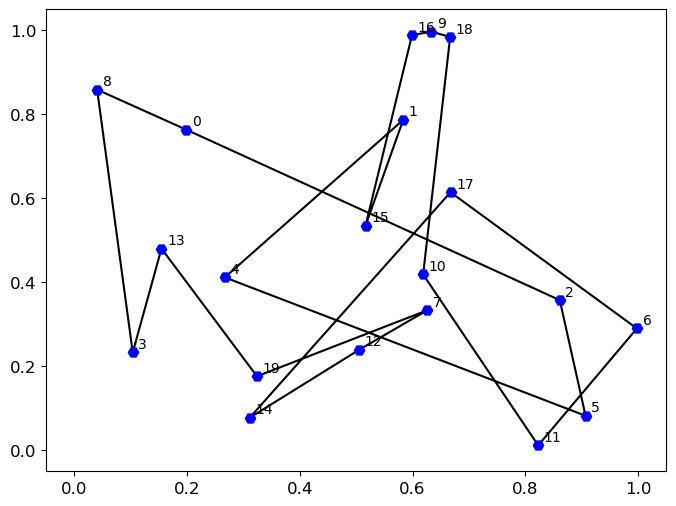

Linked list format (rec variable):
 tensor([ 2, 15,  5,  8,  1,  4, 17, 19,  0, 18, 11,  6,  7,  3, 12, 16,  9, 14,
        10, 13])


In [ ]:
dataset = TSPDataset(size = 20, num_samples = 10)
batch = next(iter(DataLoader(dataset, batch_size=10)))
coordinates_first = batch['coordinates'][0]
rec = problem.get_initial_solutions(batch)

obj = problem.get_costs(batch, rec)
best_solution = rec.clone()
batch_feature = problem.input_feature_encoding(batch)
solving_state = torch.zeros((batch_feature.size(0),1), device = opts.device).long()
action = None

for t in tqdm(range(2000), disable = opts.no_progress_bar, 
              desc = 'rollout', bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}'):

     # pass through model
    action = agent.actor(problem,
                          batch_feature,
                          rec,
                          action,
                          do_sample = True)[0]

    # state trasition
    rec, rewards, obj, solving_state = problem.step(batch, 
                                                    rec, 
                                                    action, 
                                                    obj, 
                                                    solving_state, 
                                                    best_solution = best_solution)

    # record informations
    best_solution[rewards > 0] = rec[rewards > 0]
bv = obj[:,-1].reshape(10, 1).min(1)[0]

print('best cost:', bv[0])
print('best rec found:', best_solution[0])
plot_tour(best_solution[0], coordinates_first)
print('Linked list format (rec variable):\n', best_solution[0])